###  随着互联网的发展，我们处在一个信息爆炸的时代，用户常常在海量信息中变得眼花缭乱。推荐系统很好的帮助用户发现对自己有价值的信息，推荐系统正广泛应用于各大电商，社交网络中。常见的推荐系统架构如下图所示
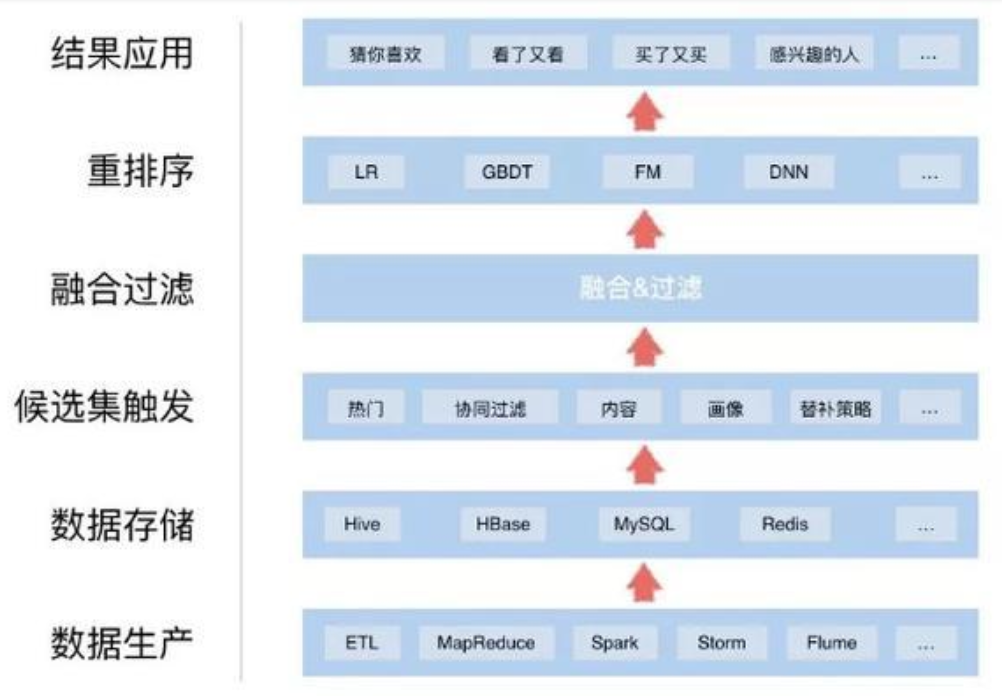

### 常见的推荐系统算法包括协同过滤，基于内容推荐，神经网络模型，隐语义模型。以下实现了一个基于协同过滤的简单例子，数据集为movielens

In [1]:
import pandas as pd
import numpy as np


#reading data
movie=pd.read_csv('movies.csv')
rating=pd.read_csv('ratings.csv')
user_id=rating['userId'].unique()
item_id=rating['movieId'].unique()
user_num=rating['userId'].unique().shape[0]
item_num=rating['movieId'].unique().shape[0]
print('user: '+str(user_num))
print('item: '+str(item_num))
print(item_id)
rating=rating.drop(['timestamp'],axis=1)
movie



user: 610
item: 9724
[     1      3      6 ... 160836 163937 163981]


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## item-based collaborative filtering



### count number of ratings for each items



In [2]:

itemScore=rating.groupby(['movieId']).count().drop(['userId'],axis=1).rename(columns={'rating':'count'})
itemScore
item_new=rating.join(itemScore,on='movieId')
item_new

,userId,movieId,rating,count
0,1,1,4.0,215
1,1,3,4.0,52
2,1,6,4.0,102
3,1,47,5.0,203
4,1,50,5.0,204
...,...,...,...,...
100831,610,166534,4.0,6
100832,610,168248,5.0,7
100833,610,168250,5.0,15
100834,610,168252,5.0,25


### display top 10 popular movies



In [3]:
top10_movie=item_new.drop_duplicates(['movieId']).sort_values(['count'],ascending=False).reset_index().head(10)
top10_movie.merge(movie,on='movieId')








,index,userId,movieId,rating,count,title,genres
0,20,1,356,4.0,329,Forrest Gump (1994),Comedy|Drama|Romance|War
1,232,2,318,3.0,317,"Shawshank Redemption, The (1994)",Crime|Drama
2,16,1,296,3.0,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,34,1,593,4.0,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,166,1,2571,5.0,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,15,1,260,5.0,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,26,1,480,4.0,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,7,1,110,4.0,237,Braveheart (1995),Action|Drama|War
8,552,5,589,3.0,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi
9,28,1,527,5.0,220,Schindler's List (1993),Drama|War


In [4]:
import gc
gc.collect()
#join item_new by itself, each user contains two item record
df2=item_new.merge(item_new,on='userId')



In [5]:
df2=df2.loc[df2.movieId_x!=df2.movieId_y]
df2


,userId,movieId_x,rating_x,count_x,movieId_y,rating_y,count_y
1,1,1,4.0,215,3,4.0,52
2,1,1,4.0,215,6,4.0,102
3,1,1,4.0,215,47,5.0,203
4,1,1,4.0,215,50,5.0,204
5,1,1,4.0,215,70,3.0,55
...,...,...,...,...,...,...,...
60894130,610,170875,3.0,3,166528,4.0,27
60894131,610,170875,3.0,3,166534,4.0,6
60894132,610,170875,3.0,3,168248,5.0,7
60894133,610,170875,3.0,3,168250,5.0,15


### calculate cosine similarity between two items
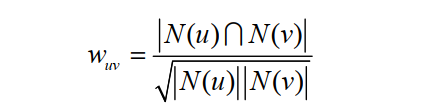
1：find people  who like item i   
2:find people who like item i and item j

In [6]:
#find concurrence number between every 2 items
test=df2.groupby(['movieId_x','movieId_y']).count()
test

userId  rating_x  count_x  rating_y  count_y
movieId_x movieId_y                                              
1         2              68        68       68        68       68
          3              32        32       32        32       32
          4               2         2        2         2        2
          5              32        32       32        32       32
          6              58        58       58        58       58
...                     ...       ...      ...       ...      ...
193609    134130          1         1        1         1        1
          164179          1         1        1         1        1
          177765          1         1        1         1        1
          183897          1         1        1         1        1
          187593          1         1        1         1        1

[26315344 rows x 5 columns]

In [7]:
import math
test1=test[['userId']].head(1000)
test1.columns=['concurence']
sim_list=[]
def cal_sim(df1,df2,leftname='movieId_x',rightname='movieId_y'):
    for i in df1.itertuples():
        left=i[0][0]
        right=i[0][1]
        concurence=i[1]
        score_left=df2.loc[df2[leftname]==left].count_x.unique()[0]
        score_right=df2.loc[df2[rightname]==right].count_y.unique()[0]
        cos_sim=concurence/math.sqrt(score_left*score_right)
        sim_list.append(cos_sim)
    df1['sim']=sim_list
cal_sim(test1,df2)
test1



    
    




concurence       sim
movieId_x movieId_y                      
1         2                  68  0.442174
          3                  32  0.302642
          4                   2  0.051554
          5                  32  0.311769
          6                  58  0.391660
...                         ...       ...
          1348               10  0.170499
          1349                1  0.068199
          1350               12  0.174482
          1351                3  0.118125
          1352                2  0.096449

[1000 rows x 2 columns]